In [1]:
import os
# os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import tensorflow as tf
import keras
from keras import ops
from keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization, Dropout, GRU, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode

pd.options.display.max_seq_items = 50000

In [2]:
# Path to the data directory
data_dir = Path("DataGenerated/")

# Get list of all the images
images_path = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split("_")[0] for img in images_path]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))
num_classes = len(characters)

print("Number of images found: ", len(images_path))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 32
# Desired image dimensions
img_width = 200
img_height = 50

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print("Max lenght: ", max_length)

Number of images found:  80000
Number of labels found:  80000
Number of unique characters:  35
Characters present:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Max lenght:  6


In [3]:
zoom_range = [0.95, 1.05]  # Rango de zoom (0.8 a 1.2 veces el tamaño original)
rotation_range = 15  # Rango de rotación en grados
# Create a mapping of characters to integers and integers to characters
char_to_int = {char: i for i, char in enumerate(characters)}
char_to_int = {"unk":-1}
int_to_char = {i: char for char, i in char_to_int.items()}

# Define a function to preprocess an image
def random_zoom(image, zoom_range):
    zoom_factor = np.random.uniform(zoom_range[0], zoom_range[1])
    crop_height = int(img_height / zoom_factor)
    crop_width = int(img_width / zoom_factor)
    image = tf.image.resize_with_crop_or_pad(image, crop_height, crop_width)
    return tf.image.resize(image, [img_height, img_width])

def random_rotation(image, rotation_range):
  # Genera un ángulo de rotación aleatorio entre -rotation_range y rotation_range.
  random_angle = tf.random.uniform(shape=[], minval=-rotation_range, maxval=rotation_range, dtype=tf.float32)
  # Convierte el ángulo de grados a radianes.
  angle_radians = random_angle * tf.constant(3.14159265358979323846 / 180.0)
  # Rota la imagen usando tf.image.rot90.
  rotated_image = tf.image.rot90(image, tf.cast(tf.round(angle_radians / (tf.constant(3.14159265358979323846 / 2))), tf.int32))
  return rotated_image


def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Imagen en escala de grises
    image = tf.image.resize(image, (img_height, img_width))
    # Aplicar zoom aleatorio
    image = random_zoom(image, zoom_range)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Aplicar rotación aleatoria
    # image = random_rotation(image, rotation_range)
    return image

# Preprocess images and labels
images = [preprocess_image(image_path) for image_path in images_path]
encoded_labels = [[char_to_int[char] for char in label] for label in labels]
# Create TensorFlow Datasets
dataset = tf.data.Dataset.from_tensor_slices((images, encoded_labels))

# shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(images))

# Define las proporciones para cada conjunto
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calcula los tamaños de cada conjunto
total_samples = len(images_path)
train_size = int(train_ratio * total_samples)
val_size = int(val_ratio * total_samples)
test_size = total_samples - train_size - val_size

# Divide los datos en los tres conjuntos
train_dataset = dataset.take(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = dataset.skip(train_size).take(val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = dataset.skip(train_size + val_size).take(test_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

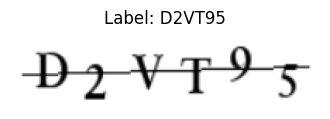

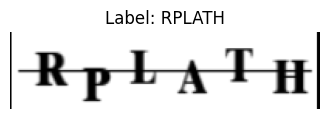

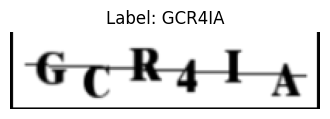

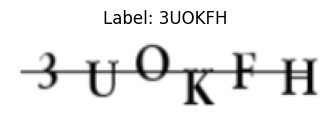

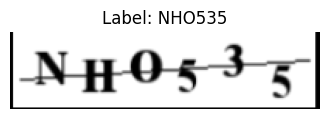

In [4]:
def visualize_random_samples(dataset, int_to_char, num_samples=5):
    # Create an iterator for the dataset
    dataset_iter = iter(dataset)
    # Iterate through the random samples and visualize them
    for i in range(num_samples):
        image, label = next(dataset_iter)
        # Decode the label (convert integers to characters)
        label = [int_to_char[int(x)] for x in label[0].numpy()]
        # Display the image and label
        plt.figure(figsize=(4, 2))
        plt.imshow(image[0, :, :, 0], cmap='gray')
        plt.title("Label: " + ''.join(label))
        plt.axis('off')
        plt.show()

# Example usage:
visualize_random_samples(val_dataset, int_to_char, num_samples=5)

In [91]:
# Compile the model with CTC loss
def ctc_loss(y_true, y_pred):
    batch_size = tf.shape(y_pred)[0]
    input_length = tf.fill((batch_size, 1), tf.shape(y_pred)[1])
    label_length = tf.fill((batch_size, 1), max_length)
    # Imprime valores para depurar
    loss = ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss
    
def build_model():
    # Entradas del modelo
    input_img = layers.Input(shape=(img_height, img_width, 1), name="image", dtype="float32")
    # labels_l = Input(name="label", shape=(num_classes,), dtype="float32")

    # Convolutional layers
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    x = layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 1), name="pool3")(x) # Pooling over time dimension
    # Capa de Activacion
    x = layers.Reshape(target_shape=(img_width // 8, (img_height // 4) * 256), name="reshape1")(x)
    x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
    x = layers.Dropout(0.2)(x)

    # Recurrent layers (Bidirectional LSTM)
    # x = layers.Reshape(target_shape=(img_width // 16, (img_height // 4) * 256), name="reshape")(x)
    # x = layers.Reshape(target_shape=(6, 128), name="reshape2")(x)
    x = layers.Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)

    # Output layer
    output = layers.Dense(num_classes + 1, activation="softmax", name="dense2")(x)
    # Definir el modelo
    model = keras.models.Model(inputs=[input_img], outputs=output, name="ocr_model_v1")
    return model

# Construir y resumir el modelo
model = build_model()
model.compile(optimizer=Adam(), loss=ctc_loss)
model.summary()

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 50, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 50, 200, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 50, 200, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 25, 100, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 25, 100, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 25, 100, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 12, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 12, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 12, 50, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 50, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape1 (Reshape)              │ (None, 25, 3072)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 25, 64)         │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 25, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 25, 36)         │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 775,012 (2.96 MB)

 Trainable params: 774,116 (2.95 MB)

 Non-trainable params: 896 (3.50 KB)

In [7]:
# Todo restore epoch count.
epochs = 15
early_stopping_patience = 5
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1422s 711ms/step - loss: 0.0702 - val_loss: 0.0645
Epoch 2/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1451s 725ms/step - loss: 0.0648 - val_loss: 0.0581
Epoch 3/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1288s 644ms/step - loss: 0.0654 - val_loss: 0.2398
Epoch 4/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1407s 704ms/step - loss: 0.0751 - val_loss: 0.0533
Epoch 5/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5354s 3s/step - loss: 0.0594 - val_loss: 0.0546
Epoch 6/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1267s 634ms/step - loss: 0.0634 - val_loss: 0.0244
Epoch 7/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1268s 634ms/step - loss: 0.0572 - val_loss: 0.0913
Epoch 8/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1287s 643ms/step - loss: 0.0662 - val_loss: 0.0213
Epoch 9/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1301s 651ms/step - loss: 0.0563 - val_loss: 0.0449
Epoch 10/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1279s 640ms/step - loss: 0.0560 - val_loss: 0.0258
Epoch 11/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1280s 640ms/step - loss: 0.05

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
(32, 25, 36)
32 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
(32, 25, 36)
32 25


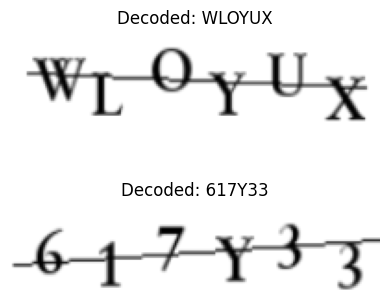

In [62]:
def decode_and_visualize_samples(model, dataset, int_to_char, num_samples=5):
    # Create an iterator for the dataset
    dataset_iter = iter(dataset)
    # Create a subplot grid
    fig, axes = plt.subplots(num_samples, 1, figsize=(4, 2 * num_samples))
    
    # Iterate through the random samples, decode, and visualize them
    for i in range(num_samples):
        image, label = next(dataset_iter)
        # Make predictions using the model
        predictions = model.predict(image)
        print(predictions.shape)
        # Decode the predictions using CTC decode
        decoded, _ = ctc_decode(predictions, input_length=tf.fill((batch_size,), 25), greedy=True)
        print(len(decoded[0]),len(decoded[0][0]))
        # Convert decoded labels to characters
        decoded_labels = [int_to_char[int(x)] for x in decoded[0][0,:max_length].numpy()]
        # Display the image and decoded label
        axes[i].imshow(image[0, :, :, 0], cmap='gray')
        axes[i].set_title("Decoded: " + ''.join(decoded_labels))
        axes[i].axis('off')
    # Adjust spacing and display the grid
    plt.tight_layout()
    plt.show()

# Example usage:
decode_and_visualize_samples(model, test_dataset, int_to_char, num_samples=2)

In [68]:
from PIL import Image, ImageOps

# Abrir la imagen PNG con fondo transparente
img = Image.open('captcha siguelo.png').convert("RGBA")
white_background = Image.new("RGBA", img.size, "BLACK")
combined = Image.alpha_composite(white_background, img)
gray = combined.convert("L")
inverted = ImageOps.invert(gray)

# Guardar la imagen resultante
inverted.save('imagen_modificada.png')

def decode_image(model, image, int_to_char):
  
  print(image.shape)
  predictions = model.predict(image)
  print(predictions.shape)

  batch_temp = tf.shape(image)[0]
  # Decode the predictions using CTC decode
  decoded, _ = ctc_decode(predictions, input_length=tf.fill((batch_temp,), 25), greedy=True)
  print(decoded)
  print(decoded[0][0,:max_length])

  # Convert decoded labels to characters
  decoded_labels = [int_to_char[int(x)] for x in decoded[0][0,:max_length].numpy()]
  return decoded_labels


In [69]:
# 1. Read image
img = tf.io.read_file('imagen_modificada.png')
img = tf.image.decode_png(img, channels=1)  # Imagen en escala de grises
img = tf.image.resize(img, (img_height, img_width))
# Aplicar zoom aleatorio
img = tf.image.convert_image_dtype(img, tf.float32)
# Expandir dimensiones para agregar el batch size
img = tf.expand_dims(img, axis=0)
print(decode_image(model, img, int_to_char))

(1, 50, 200, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
(1, 25, 36)
[<tf.Tensor: shape=(1, 25), dtype=int64, numpy=
array([[19, 34, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=int64)>]
tf.Tensor([19 34 -1 -1 -1 -1], shape=(6,), dtype=int64)


KeyError: -1

In [703]:
import os
import random
from PIL import Image

# Ruta de la carpeta con las imágenes
input_folder = Path("DataGenerated/")
output_folder = input_folder  # Guardar en la misma carpeta

# Crear la carpeta de salida si no existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Extensiones de imágenes soportadas
supported_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

# Procesar cada archivo en la carpeta
for filename in os.listdir(input_folder):
    if filename.lower().endswith(supported_extensions):
        # Ruta completa del archivo de entrada
        input_path = os.path.join(input_folder, filename)
        
        # Abrir la imagen
        image = Image.open(input_path)
        
        # Rotar aleatoriamente 10 grados a la izquierda o derecha
        angle = random.choice([-5, 5])
        rotated_image = image.rotate(angle, expand=True)
        
        # Crear el nombre del archivo de salida
        name, ext = os.path.splitext(filename)
        output_filename = f"{name}g{ext}"
        output_path = os.path.join(output_folder, output_filename)
        
        # Guardar la imagen rotada
        rotated_image.save(output_path)

        print(f"Imagen guardada: {output_filename}")

Imagen guardada: 11P66K_2447g.png
Imagen guardada: 125E4X_5832g.png
Imagen guardada: 126NHA_4879g.png
Imagen guardada: 12G7Q7_2916g.png
Imagen guardada: 12I47I_2652g.png
Imagen guardada: 12IRD8_2912g.png
Imagen guardada: 12KJA1_3756g.png
Imagen guardada: 12Q5SL_332g.png
Imagen guardada: 12QVX1_3336g.png
Imagen guardada: 12TPL1_5744g.png
Imagen guardada: 12WQ8D_665g.png
Imagen guardada: 139I71_2079g.png
Imagen guardada: 13ERU2_4024g.png
Imagen guardada: 13NB6Q_2002g.png
Imagen guardada: 13TF9V_2713g.png
Imagen guardada: 13ZNXX_5296g.png
Imagen guardada: 144791_3043g.png
Imagen guardada: 146UAB_1098g.png
Imagen guardada: 14HDVV_1494g.png
Imagen guardada: 14OBIP_3729g.png
Imagen guardada: 14QHHD_1643g.png
Imagen guardada: 14SS2D_1329g.png
Imagen guardada: 156IZO_699g.png
Imagen guardada: 15AXVJ_4349g.png
Imagen guardada: 15E811_5169g.png
Imagen guardada: 15NE2B_3675g.png
Imagen guardada: 15QDIM_3133g.png
Imagen guardada: 161QZX_3898g.png
Imagen guardada: 16C1VF_4144g.png
Imagen guardada: 